## End to End Model Deployment

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn import datasets
import joblib

### 1) Data Aquisition

In [58]:
titanic = datasets.fetch_openml(name="titanic", version=1, as_frame=True)
df = pd.DataFrame(data=titanic.data, columns=titanic.feature_names)
df['target']= titanic.target
df.head()

C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,target
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


### 2) EDA

In [7]:
df.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    object  
 12  home.dest  745 non-null    object  
 13  target     1309 non-null   category
dtypes: category(3), float64(5), object(6)
memory usage: 116.8+ KB


C:\Users\ASCC\AppData\Local\Temp\ipykernel_7708\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

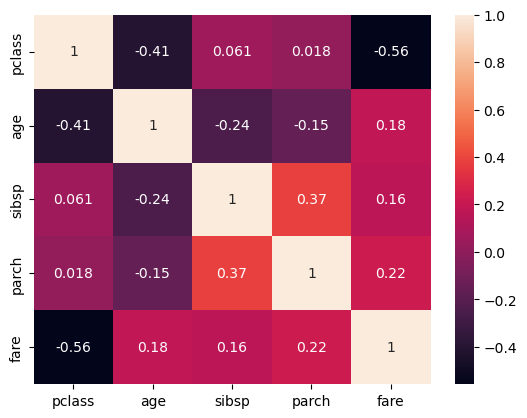

In [9]:
sns.heatmap(df.corr(), annot=True)

In [11]:
df['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

<Axes: xlabel='sex', ylabel='count'>

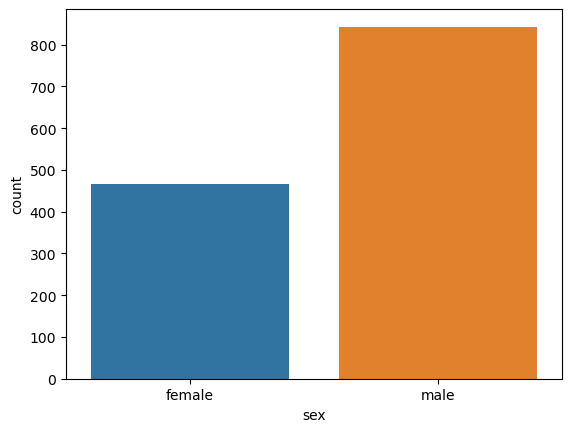

In [10]:
sns.countplot(df, x="sex")

In [13]:
df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

<Axes: xlabel='embarked', ylabel='count'>

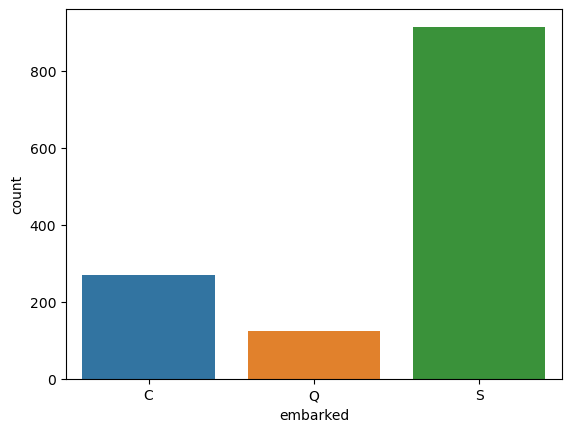

In [14]:
sns.countplot(df, x="embarked")

<Axes: xlabel='age', ylabel='Count'>

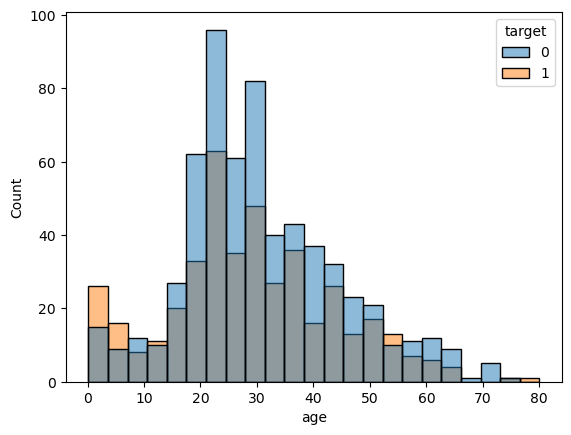

In [28]:
sns.histplot(df, x='age', hue='target')

In [18]:
df['sibsp'].value_counts()

0.0    891
1.0    319
2.0     42
4.0     22
3.0     20
8.0      9
5.0      6
Name: sibsp, dtype: int64

<Axes: xlabel='sibsp', ylabel='count'>

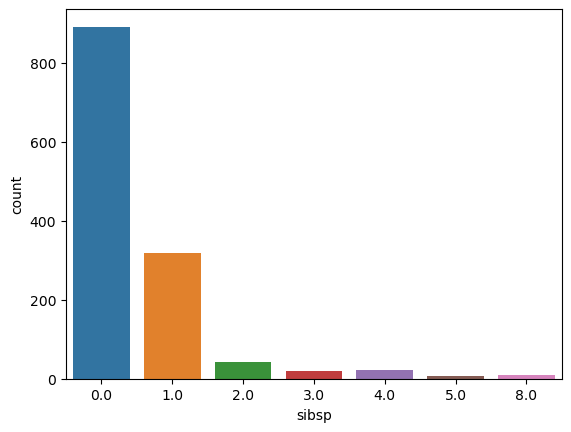

In [17]:
sns.countplot(df, x='sibsp')

In [19]:
df['parch'].value_counts()

0.0    1002
1.0     170
2.0     113
3.0       8
4.0       6
5.0       6
6.0       2
9.0       2
Name: parch, dtype: int64

<Axes: xlabel='parch', ylabel='count'>

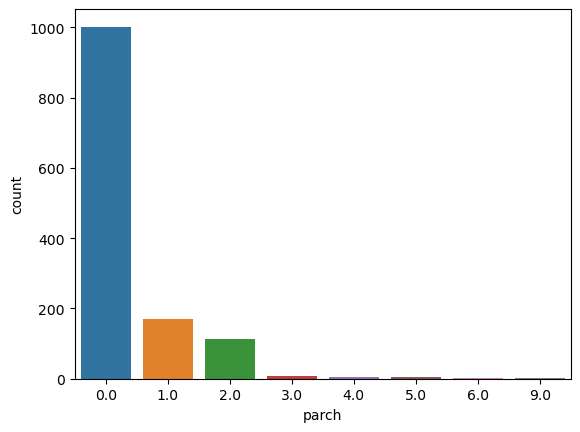

In [20]:
sns.countplot(df, x='parch')

In [22]:
df['pclass'].value_counts()

3.0    709
1.0    323
2.0    277
Name: pclass, dtype: int64

<Axes: xlabel='pclass', ylabel='count'>

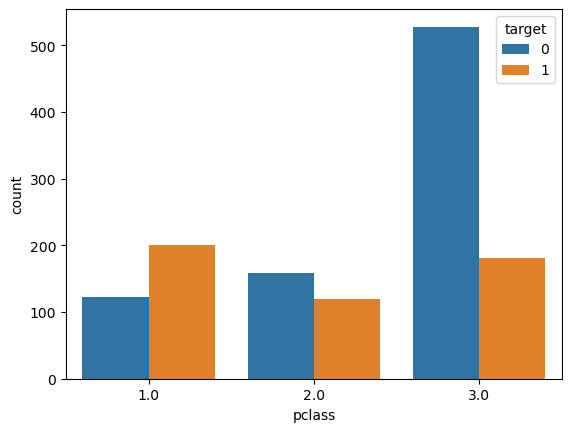

In [26]:
sns.countplot(df, x='pclass', hue='target')

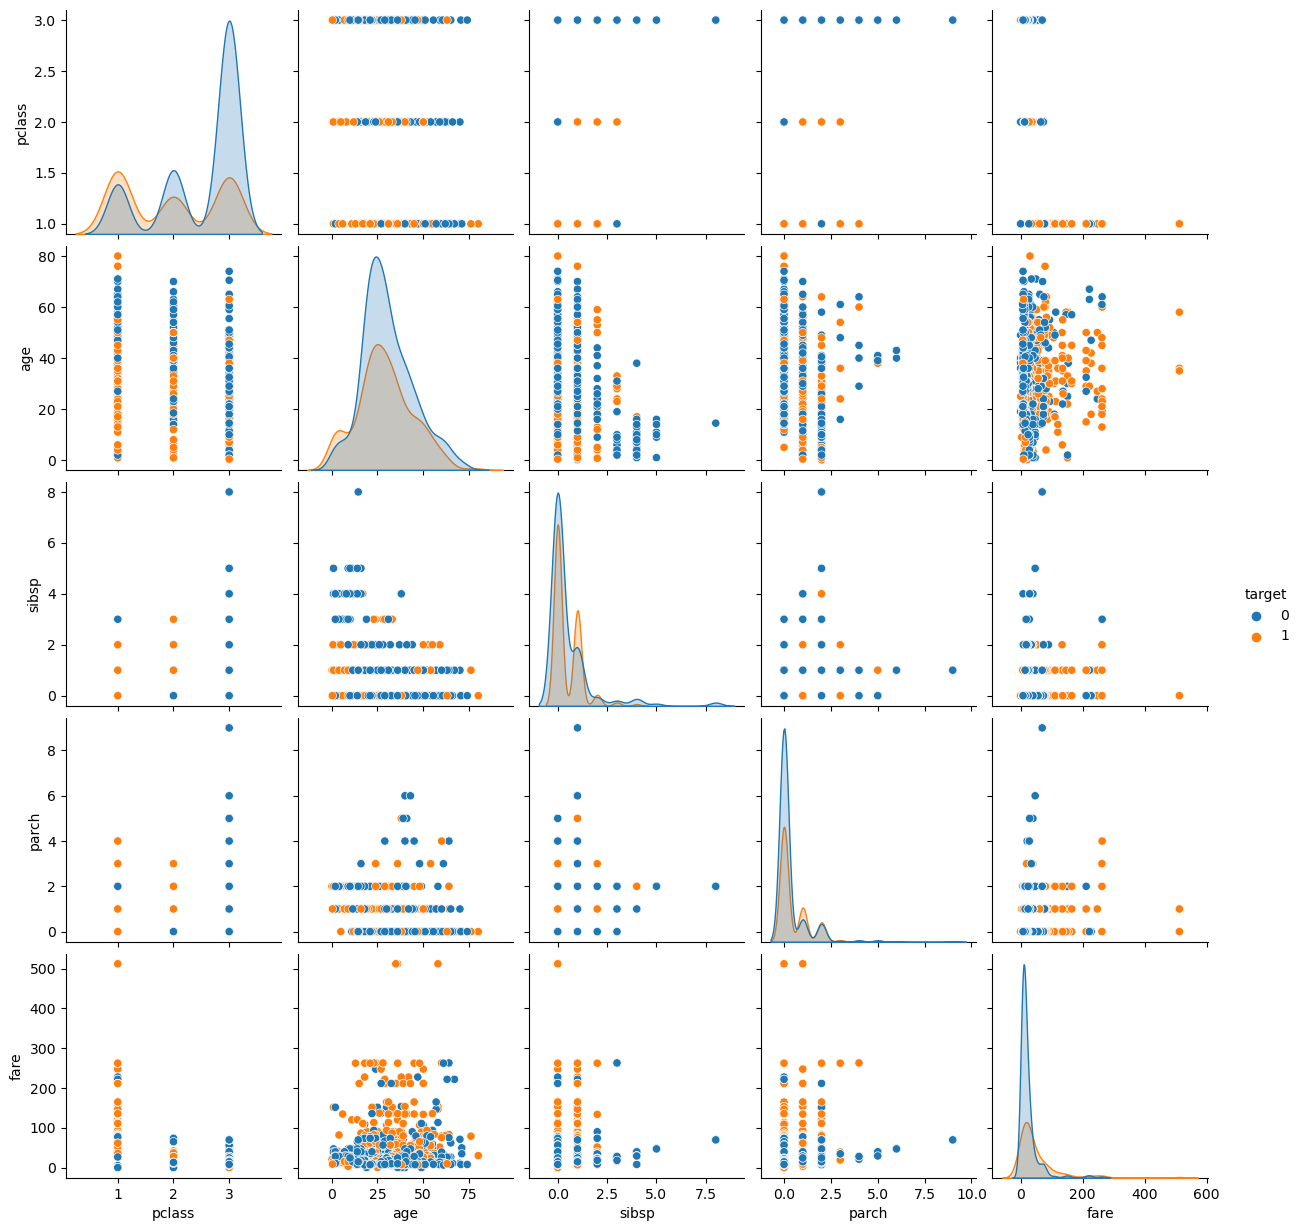

In [25]:
sns.pairplot(df, hue='target')

## 3) Preprocessing

### Feature Engineering

In [59]:
df.drop(['name', 'cabin', 'body', 'fare', 'ticket', 'home.dest', 'boat'], axis=1, inplace=True)
df.head()

,pclass,sex,age,sibsp,parch,embarked,target
0,1.0,female,29.0000,0.0,0.0,S,1
1,1.0,male,0.9167,1.0,2.0,S,1
2,1.0,female,2.0000,1.0,2.0,S,0
3,1.0,male,30.0000,1.0,2.0,S,0
4,1.0,female,25.0000,1.0,2.0,S,0


In [60]:
df['Travel_alone'] = np.where((df['sibsp']+df['parch'])>0, 1, 0)
df.head()

,pclass,sex,age,sibsp,parch,embarked,target,Travel_alone
0,1.0,female,29.0000,0.0,0.0,S,1,0
1,1.0,male,0.9167,1.0,2.0,S,1,1
2,1.0,female,2.0000,1.0,2.0,S,0,1
3,1.0,male,30.0000,1.0,2.0,S,0,1
4,1.0,female,25.0000,1.0,2.0,S,0,1


In [61]:
df.drop(['parch', 'sibsp'], axis=1, inplace=True)
df

,pclass,sex,age,embarked,target,Travel_alone
0,1.0,female,29.0000,S,1,0
1,1.0,male,0.9167,S,1,1
2,1.0,female,2.0000,S,0,1
3,1.0,male,30.0000,S,0,1
4,1.0,female,25.0000,S,0,1
...,...,...,...,...,...,...
1304,3.0,female,14.5000,C,0,1
1305,3.0,female,NaN,C,0,1
1306,3.0,male,26.5000,C,0,0
1307,3.0,male,27.0000,C,0,0


## 3)Train Test Split

In [62]:
X = df.drop('target', axis=1)
y = df['target']
X_Train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, random_state=54)

### Encoding Categorical Columns

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   pclass        1309 non-null   float64 
 1   sex           1309 non-null   category
 2   age           1046 non-null   float64 
 3   embarked      1307 non-null   category
 4   target        1309 non-null   category
 5   Travel_alone  1309 non-null   int32   
dtypes: category(3), float64(2), int32(1)
memory usage: 29.9 KB


In [83]:
categorical_encode_transformer = Pipeline(steps=
                                    [
                                        ('oe1', OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32))
                                    ]
                                   )
numeric_imputer = Pipeline(
                                    [
                                        ('si1', SimpleImputer(missing_values=np.nan, strategy='mean'))
                                    ]
                                   )
categorical_Nominal_transformer = Pipeline(steps=
                                    [
                                        ('si1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                        ('ohe', OneHotEncoder(drop='first',handle_unknown='ignore'))
                                    ]
                                   )

In [84]:
lb = LabelEncoder()
lb.fit(df['target'])
df['target'] = lb.transform(df['target'])
df.head(5)

,pclass,sex,age,embarked,target,Travel_alone
0,1.0,female,29.0000,S,1,0
1,1.0,male,0.9167,S,1,1
2,1.0,female,2.0000,S,0,1
3,1.0,male,30.0000,S,0,1
4,1.0,female,25.0000,S,0,1


In [85]:
preprocessor = ColumnTransformer(transformers=
                                     [
                                         ('numeric', numeric_imputer, [2]),
                                         ('categoricalimputer', categorical_encode_transformer, [1]),
                                         ('categoricalNominal', categorical_Nominal_transformer, [3])
                                     ], remainder='passthrough'
                                 )

In [86]:
params = {"penalty":['l2'],
          "solver": ['lbfgs']
         }
#'liblinear','sag', 'saga'
model = Pipeline(steps=
                      [
                          ('preprocessor', preprocessor),
                          ('standard', StandardScaler()),
                          ('Estimator', GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5, n_jobs=-1))
                      ]
                     )
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('si1',
                                                                   SimpleImputer())]),
                                                  [2]),
                                                 ('categoricalimputer',
                                                  Pipeline(steps=[('oe1',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'numpy.int32'>,
                                                                                 sparse_output=False))]),
                                                  [1]),
                                                 ('categoricalNominal',
                                                  Pipeline(steps=[('si1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [3])])),
                ('standard', StandardScaler()),
                ('Estimator',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'penalty': ['l2'],
                                          'solver': ['lbfgs']}))])

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   pclass        1309 non-null   float64 
 1   sex           1309 non-null   category
 2   age           1046 non-null   float64 
 3   embarked      1307 non-null   category
 4   target        1309 non-null   int64   
 5   Travel_alone  1309 non-null   int32   
dtypes: category(2), float64(2), int32(1), int64(1)
memory usage: 38.7 KB


### Handling Outliers

<Axes: xlabel='age'>

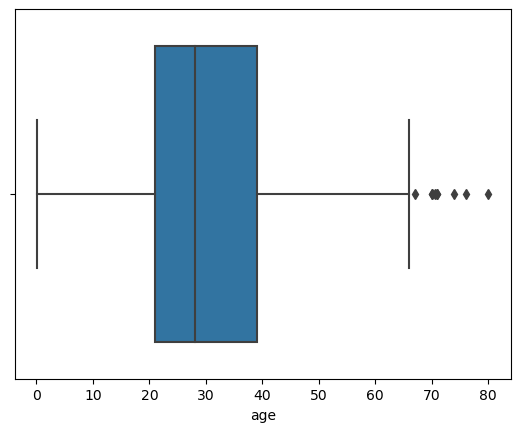

In [46]:
sns.boxplot(x='age', data=df)

In [88]:
model.fit(X_Train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('si1',
                                                                   SimpleImputer())]),
                                                  [2]),
                                                 ('categoricalimputer',
                                                  Pipeline(steps=[('oe1',
                                                                   OneHotEncoder(drop='first',
                                                                                 dtype=<class 'numpy.int32'>,
                                                                                 sparse_output=False))]),
                                                  [1]),
                                                 ('categoricalNominal',
                                                  Pipeline(steps=[('si1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [3])])),
                ('standard', StandardScaler()),
                ('Estimator',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'penalty': ['l2'],
                                          'solver': ['lbfgs']}))])

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   pclass        1309 non-null   float64 
 1   sex           1309 non-null   category
 2   age           1046 non-null   float64 
 3   embarked      1307 non-null   category
 4   target        1309 non-null   int32   
 5   Travel_alone  1309 non-null   int32   
dtypes: category(2), float64(2), int32(2)
memory usage: 33.6 KB


### Cross Validate

In [89]:
cross_val_score(model, X_Train, y_train, cv=5, scoring='f1').mean()

C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "C:\Users\ASCC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1573, in precision_recall_fscor

nan

### Evaluation

In [ ]:
f1 = f1_score(y_hold, model.predict(X_hold))
print("F1-Score : ", f1)

### Train on Whole Dataset

In [ ]:
model.fit(X, y)

### Pickle the Model

joblib.dump(pipeline_model, 'lr_model_adv.pkl')